In [2]:
# Attaching google drive

from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/refine-epitope-hmm/src')

Mounted at /content/drive/


In [3]:
!pip install pomegranate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pomegranate: filename=pomegranate-0.14.8-cp37-cp37m-linux_x86_64.whl size=15068182 sha256=cef6c702c21f17d8ac3c800a134e1d23a3fc7974e795f132f65f8c9569a877a9
  Stored in directory: /root/.cache/pip/wheels/24/68/69/0eaab474ef1d65abedcd47de8a38ab21d221d329954d7edd24
Successfully built pomegranate


In [4]:
from __future__ import print_function, division

import os, sys
import numpy as np
import pandas as pd
import pomegranate as pg
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve


# Importing dataset to select exact epitopes and non-epitope

In [5]:
import pandas as pd 

ov_newdata = pd.read_csv('../input/Ov_newdata.csv')

In [6]:
list_exact = []
sequence=""
tipo=''
for index, row in ov_newdata.iterrows():
    if row['Info_type'] != 'NA':
      if row['Info_type']=='Exact Epitope':
        tipo = 'exact'
        sequence = sequence + row['Info_AA']
      else:        
        if tipo =='exact':
          tipo= 'noexact'
          list_exact.append(sequence)
          sequence=""

In [7]:
filted_list_exact = []
for l in list_exact:
  
  l_seq = list(l)
  if len(l_seq) > 7: 
    if len(l_seq) == 8:
        filted_list_exact.append(l)
    else:
        filted_list_exact.append(l[0:8])


In [8]:
ov_labelled_prots = pd.read_csv('../input/Ov_labelled_prots.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
list_non_epitope = []
sequence=""
tipo=''
for index, row in ov_labelled_prots.iterrows():
    if row['Class'] != 'NA':
      if row['Class']==-1:
        tipo = 'non-exact'
        sequence = sequence + row['Info_AA']
      else:        
        if tipo =='non-exact':
          tipo= 'exact'
          list_non_epitope.append(sequence)
          sequence=""


In [10]:
filted_list_non_epitope = []
for l in list_non_epitope:
  
  l_seq = list(l)
  if len(l_seq) > 7: 
    if len(l_seq) == 8:
      filted_list_non_epitope.append(l)
    else:
      filted_list_non_epitope.append(l[0:8])


In [11]:
#list_non_epitope_and_exact_epitope=  filted_list_non_epitope[0:50] + filted_list_exact[0:50]

## Calculating initial emission probabilities for the exact epitope

In [12]:
# Each sequence has 15 caracteres/columns
# There are 20 letters possible

import numpy

lists =[]

for seq in filted_list_exact:
  lists.append(list(seq))

matrix_exact = pd.DataFrame(lists)

In [13]:
emission_dic_exact = []

for col in matrix_exact.columns:
  emission_dic_exact.append((matrix_exact[col].value_counts()/matrix_exact[col].value_counts().sum()).to_dict())

In [14]:
import collections

rows = []

od_emission_dic_exact = []

for e in emission_dic_exact:
  od_emission_dic_exact.append(collections.OrderedDict(sorted(e.items())))

for e in od_emission_dic_exact:
  rows.append(e.values())
  
df_prob_per_position = pd.DataFrame(rows, columns = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']) 

emission_avg_epitope = dict()

for col in df_prob_per_position.columns:
  emission_avg_epitope[col] = df_prob_per_position[col].sum()/len(df_prob_per_position)

emission_avg_epitope

{'A': 0.06976010101010101,
 'C': 0.016098484848484848,
 'D': 0.061237373737373736,
 'E': 0.07891414141414141,
 'F': 0.039141414141414144,
 'G': 0.05934343434343434,
 'H': 0.017992424242424244,
 'I': 0.06849747474747475,
 'K': 0.05839646464646465,
 'L': 0.0836489898989899,
 'M': 0.021464646464646464,
 'N': 0.05366161616161616,
 'P': 0.06218434343434343,
 'Q': 0.05523989898989899,
 'R': 0.04861111111111111,
 'S': 0.0735479797979798,
 'T': 0.04797979797979798,
 'V': 0.049873737373737376,
 'W': 0.008522727272727274,
 'Y': 0.025883838383838384}

##Calculating initial emission probabilties for non-epitope

In [15]:
# Each sequence has 15 carcteres/columns
# There are 20 letters possible

import numpy

lists =[]
for seq in filted_list_non_epitope:
 
  lists.append(list(seq))

matrix_non_epitope = pd.DataFrame(lists)


In [16]:
non_epitope_emission_dic = []

for col in matrix_non_epitope.columns:
  non_epitope_emission_dic.append((matrix_non_epitope[col].value_counts()/matrix_non_epitope[col].value_counts().sum()).to_dict())


In [ ]:
import collections

rows = []

# dictionary ordered
od_non_epitope_emission_dic = []

for e in non_epitope_emission_dic:
  od_non_epitope_emission_dic.append(collections.OrderedDict(sorted(e.items())))

for e in od_non_epitope_emission_dic:
  rows.append(e.values())
  
df_prob_per_position = pd.DataFrame(rows, columns = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']) 

emission_avg_non_epitope = dict()

for col in df_prob_per_position.columns:
  emission_avg_non_epitope[col] = df_prob_per_position[col].sum()/len(df_prob_per_position)


emission_avg_non_epitope

## Bulding a HMM - positive


In [18]:
# HMM parameters
numStates = 2
max_iterations = 5000    # max number of steps in Baum-Welch
stop_threshold = 0.0001 # log probability change cutoff in Baum-Welch

In [19]:
emission_probabilities = [emission_avg_non_epitope, emission_avg_epitope]

In [20]:
!apt-get install python-dev graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

In [21]:
from pomegranate import *

d1 = DiscreteDistribution(emission_probabilities[1])
d2 = DiscreteDistribution(emission_probabilities[1])
d3 = DiscreteDistribution(emission_probabilities[1])


e1 = State(d1, name="e1")
e2 = State(d2, name="e2")
#e3 = State(d3, name="e3")


hmm_positive = HiddenMarkovModel('Epitope-positive')

hmm_positive.add_states([e1, e2])

hmm_positive.add_transition(hmm_positive.start, e1, 1)

hmm_positive.add_transition(e1, e1, 0.9)
hmm_positive.add_transition(e1, e2, 0.1)
hmm_positive.add_transition(e2, e2, 0.9)
#hmm_positive.add_transition(e2, e3, 0.1)
#hmm_positive.add_transition(e3, e3, 0.9)


hmm_positive.add_transition(e2, hmm_positive.end, 0.1)


hmm_positive.bake()

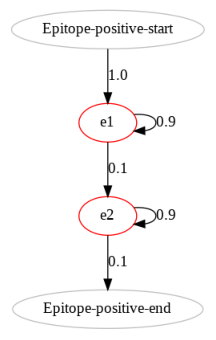

In [22]:
plt.figure(figsize=(6,6))

hmm_positive.plot()

In [23]:
from sklearn.utils import shuffle

#Training

#Training set containing true exact epitopes
training_filted_list_exact = filted_list_exact[0:230]

#Training set containing non-epitopes
training_filted_list_non_epitope = filted_list_non_epitope[0:450]

#Combining training set containing true exact epitopes and non-epitopes
training =  training_filted_list_non_epitope + training_filted_list_exact
training_set_pg = [list(str(p)) for p in training]


#Testing

#Testing set containing true exact epitopes (40)
testing_filted_list_exact = filted_list_exact[231:271]

# Setting exact sequences to label 1
df_testing_filted_list_exact = pd.DataFrame(testing_filted_list_exact, columns = ['sequence']) 
df_testing_filted_list_exact['label'] = 1


#Testing set containing non-epitopes (120)
testing_filted_list_non_epitope = filted_list_non_epitope[451:571]
 
# Setting non-epitope to label 0
testing_filted_list_non_epitope = pd.DataFrame(testing_filted_list_non_epitope, columns = ['sequence']) 
testing_filted_list_non_epitope['label'] = 0

#Combining testing set containing true exact epitopes and non-epitopes

frames = [df_testing_filted_list_exact, testing_filted_list_non_epitope]

testing = pd.concat(frames)

testing = shuffle(testing)


In [24]:
training_set_pg_positive = [list(str(p)) for p in training_filted_list_exact]

In [25]:
#%%time 

# train the model using Baum-Welch

hmm_trained_positive = hmm_positive.fit(
    training_set_pg_positive,
    algorithm = 'baum-welch',
    stop_threshold = stop_threshold,
    max_iterations = max_iterations,
    verbose = False,
    n_jobs = 4
)

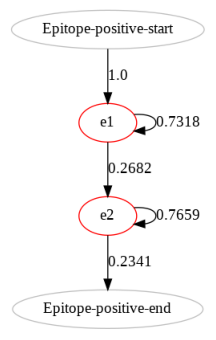

In [26]:
plt.figure(figsize=(6,6))

hmm_trained_positive.plot()

In [27]:
import pandas as pd

#QQIDPLDAEHSRGFV
#CVEEDMPEKVINDSQMTLRI
#IRRLINEESEEQKAV
#EVESGAAAAAAAAGQE
#CQPCPPGPPGP
#GGVFFEDGTRR
#WADDEWLKTVL
#QIEQQGSKNGK
#SMAAKKKKRNNMSRSRD
#AEEGSNGNVRE


sequences_containing_region = ['LLLLAITALEAGVVKRYNKRQQIDPLDAEHSRGFVCVEEDMPEKVINDSQMTLRI',
'GPDTNGSQFFICTECVEEDMPEKVINDSQMTLRILMDFDSRIKAYKFVSYAAVTFSTVA',
'GPPGPPGDAGPDGTPGQPGGVGAPGPVGPKGPPIRRLINEESEEQKAVQPGAPGVPGEKGICPKYCAIDGGVFFEDG',
'EKVLQAGFVPFGEIVSIEVESGAAAAAAAAGQEAAIDNMNDSELFGRTIRCN',
'YEGSHFHRIIPRFMVQGGDFTKGDGTGGKSIYGCQPCPPGPPGPFKLKHSMAGIVSMANCGPDTNGSQFFICTE',
'RQAYLLGGVFFEDGTRRLEVEDATRKLRLGDFMGNPDPAL',
'DASGKRLNTREIRKRQELEQLRHEKIQALLWADDEWLKTVLARCSNCGSDEHKT',
'NIVCTACGGAGHIAKDCKNPRQIEQQGSKNGKKPGLGSGSGGSGYKPKNYSLPSGTPI',
'GINSMAAKKKKRNNMSRSRDTDVPLYINAVFHESFIEVNEKGTEAAAASAVGIFLRSAPITLA',
'KSHSVPPEITGSSTPVCTTNVVFDGWEAEEGSNGNVREDEKITANYE']

#list_exact_no_epitope = list_traing_exact_no_exact[0:32]

df_sequences_containing_region = pd.DataFrame(columns = ['sequences_containing_region','sliced','position', 'probability'])

count=0;
for sequence_containing_region in sequences_containing_region:
  length_sequence_containing_region = len(sequence_containing_region)
  position=0;
 
  while position <= length_sequence_containing_region - 8:
    window = sequence_containing_region[position:position + 8]
    sliding_window = window
    #window_likelihood = hmm2.compute_likelihood(sliding_window, split_level='CHARACTER')
    window_likelihood = hmm_trained_positive.log_probability(list(str(sliding_window)))
    df_sequences_containing_region.loc[count] = [sequence_containing_region, window, position, window_likelihood]
    position = position + 1;
    count = count + 1;

groupby_df_sequences_containing_region = df_sequences_containing_region.groupby(["sequences_containing_region"]).apply(lambda x: x.sort_values(["probability"], ascending = False)).reset_index(drop=True)

prob_best_sliding_window = groupby_df_sequences_containing_region.groupby(["sequences_containing_region"]).head(1)

groupby_df_sequences_containing_region

prob_best_sliding_window

,sequences_containing_region,sliced,position,probability
0,DASGKRLNTREIRKRQELEQLRHEKIQALLWADDEWLKTVLARCSN...,DASGKRLN,0,-23.986560
47,EKVLQAGFVPFGEIVSIEVESGAAAAAAAAGQEAAIDNMNDSELFG...,AAAAAAAA,22,-22.287403
92,GINSMAAKKKKRNNMSRSRDTDVPLYINAVFHESFIEVNEKGTEAA...,EAAAASAV,43,-22.477410
148,GPDTNGSQFFICTECVEEDMPEKVINDSQMTLRILMDFDSRIKAYK...,AAVTFSTV,50,-24.543077
200,GPPGPPGDAGPDGTPGQPGGVGAPGPVGPKGPPIRRLINEESEEQK...,DAGPDGTP,7,-23.786174
270,KSHSVPPEITGSSTPVCTTNVVFDGWEAEEGSNGNVREDEKITANYE,EAEEGSNG,26,-24.024675
310,LLLLAITALEAGVVKRYNKRQQIDPLDAEHSRGFVCVEEDMPEKVI...,ALEAGVVK,7,-23.775543
358,NIVCTACGGAGHIAKDCKNPRQIEQQGSKNGKKPGLGSGSGGSGYK...,QIEQQGSK,21,-23.857881
409,RQAYLLGGVFFEDGTRRLEVEDATRKLRLGDFMGNPDPAL,DATRKLRL,21,-23.884534
442,YEGSHFHRIIPRFMVQGGDFTKGDGTGGKSIYGCQPCPPGPPGPFK...,GPPGPFKL,39,-24.872294


In [28]:
prob = []

for index, row in testing.iterrows():
  
  logp, path = hmm_trained_positive.viterbi(row['sequence'])
  prob.append(logp)


predictions = pd.DataFrame({'sequence':testing['sequence'], 'label':testing['label'], 'probability':prob})
predictions.head(10)

,sequence,label,probability
74,PPDVDVPT,0,-26.870744
91,LDVHIESG,0,-27.359827
68,ENSYIKTH,0,-27.565627
79,MLLRNVKN,0,-27.352286
33,SAIGGGFG,1,-27.075555
35,ALLSPRLL,1,-23.335735
11,KYCAIDGG,0,-28.312545
11,DEGIAYRG,1,-26.301824
86,KFEESKHD,0,-28.937183
66,SSDFTKIV,0,-26.029922


## Bulding a HMM - negative

In [38]:
from pomegranate import *

d1 = DiscreteDistribution(emission_probabilities[0])
d2 = DiscreteDistribution(emission_probabilities[0])
#d3 = DiscreteDistribution(emission_probabilities[1])


n1 = State(d1, name="n1")
n2 = State(d2, name="n2")
#e3 = State(d3, name="e3")


hmm_negative = HiddenMarkovModel('Epitope-negative')

hmm_negative.add_states([n1, n2])

hmm_negative.add_transition(hmm_negative.start, n1, 1)

hmm_negative.add_transition(n1, n1, 0.9)
hmm_negative.add_transition(n1, n2, 0.1)
hmm_negative.add_transition(n2, n2, 0.9)


hmm_negative.add_transition(n2, hmm_negative.end, 0.1)


hmm_negative.bake()

In [36]:
training_set_pg_negative = [list(str(p)) for p in training_filted_list_non_epitope]


In [39]:
# train the negative model using Baum-Welch

hmm_trained_negative = hmm_negative.fit(
    training_set_pg_negative,
    algorithm = 'baum-welch',
    stop_threshold = stop_threshold,
    max_iterations = max_iterations,
    verbose = False,
    n_jobs = 4
)

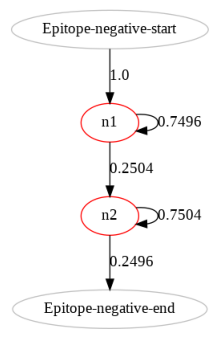

In [40]:
plt.figure(figsize=(6,6))

hmm_trained_negative.plot()

In [41]:
import pandas as pd

#QQIDPLDAEHSRGFV
#CVEEDMPEKVINDSQMTLRI
#IRRLINEESEEQKAV
#EVESGAAAAAAAAGQE
#CQPCPPGPPGP
#GGVFFEDGTRR
#WADDEWLKTVL
#QIEQQGSKNGK
#SMAAKKKKRNNMSRSRD
#AEEGSNGNVRE


sequences_containing_region = ['LLLLAITALEAGVVKRYNKRQQIDPLDAEHSRGFVCVEEDMPEKVINDSQMTLRI',
'GPDTNGSQFFICTECVEEDMPEKVINDSQMTLRILMDFDSRIKAYKFVSYAAVTFSTVA',
'GPPGPPGDAGPDGTPGQPGGVGAPGPVGPKGPPIRRLINEESEEQKAVQPGAPGVPGEKGICPKYCAIDGGVFFEDG',
'EKVLQAGFVPFGEIVSIEVESGAAAAAAAAGQEAAIDNMNDSELFGRTIRCN',
'YEGSHFHRIIPRFMVQGGDFTKGDGTGGKSIYGCQPCPPGPPGPFKLKHSMAGIVSMANCGPDTNGSQFFICTE',
'RQAYLLGGVFFEDGTRRLEVEDATRKLRLGDFMGNPDPAL',
'DASGKRLNTREIRKRQELEQLRHEKIQALLWADDEWLKTVLARCSNCGSDEHKT',
'NIVCTACGGAGHIAKDCKNPRQIEQQGSKNGKKPGLGSGSGGSGYKPKNYSLPSGTPI',
'GINSMAAKKKKRNNMSRSRDTDVPLYINAVFHESFIEVNEKGTEAAAASAVGIFLRSAPITLA',
'KSHSVPPEITGSSTPVCTTNVVFDGWEAEEGSNGNVREDEKITANYE']

#list_exact_no_epitope = list_traing_exact_no_exact[0:32]

df_sequences_containing_region = pd.DataFrame(columns = ['sequences_containing_region','sliced','position', 'probability'])

count=0;
for sequence_containing_region in sequences_containing_region:
  length_sequence_containing_region = len(sequence_containing_region)
  position=0;
 
  while position <= length_sequence_containing_region - 8:
    window = sequence_containing_region[position:position + 8]
    sliding_window = window
    #window_likelihood = hmm2.compute_likelihood(sliding_window, split_level='CHARACTER')
    window_likelihood = hmm_trained_negative.log_probability(list(str(sliding_window)))
    df_sequences_containing_region.loc[count] = [sequence_containing_region, window, position, window_likelihood]
    position = position + 1;
    count = count + 1;

groupby_df_sequences_containing_region = df_sequences_containing_region.groupby(["sequences_containing_region"]).apply(lambda x: x.sort_values(["probability"], ascending = False)).reset_index(drop=True)

prob_best_sliding_window = groupby_df_sequences_containing_region.groupby(["sequences_containing_region"]).head(1)

groupby_df_sequences_containing_region

prob_best_sliding_window

,sequences_containing_region,sliced,position,probability
0,DASGKRLNTREIRKRQELEQLRHEKIQALLWADDEWLKTVLARCSN...,DASGKRLN,0,-24.539631
47,EKVLQAGFVPFGEIVSIEVESGAAAAAAAAGQEAAIDNMNDSELFG...,EVESGAAA,17,-23.833844
92,GINSMAAKKKKRNNMSRSRDTDVPLYINAVFHESFIEVNEKGTEAA...,EKGTEAAA,39,-23.846443
148,GPDTNGSQFFICTECVEEDMPEKVINDSQMTLRILMDFDSRIKAYK...,PEKVINDS,20,-24.514849
200,GPPGPPGDAGPDGTPGQPGGVGAPGPVGPKGPPIRRLINEESEEQK...,LINEESEE,36,-23.598987
270,KSHSVPPEITGSSTPVCTTNVVFDGWEAEEGSNGNVREDEKITANYE,EAEEGSNG,26,-23.922046
310,LLLLAITALEAGVVKRYNKRQQIDPLDAEHSRGFVCVEEDMPEKVI...,LLAITALE,2,-24.439275
358,NIVCTACGGAGHIAKDCKNPRQIEQQGSKNGKKPGLGSGSGGSGYK...,KPGLGSGS,32,-23.678630
409,RQAYLLGGVFFEDGTRRLEVEDATRKLRLGDFMGNPDPAL,EDGTRRLE,11,-24.391447
442,YEGSHFHRIIPRFMVQGGDFTKGDGTGGKSIYGCQPCPPGPPGPFK...,GDGTGGKS,22,-24.200348


In [42]:
prob = []

for index, row in testing.iterrows():
  
  logp, path = hmm_trained_negative.viterbi(row['sequence'])
  prob.append(logp)


predictions = pd.DataFrame({'sequence':testing['sequence'], 'label':testing['label'], 'probability':prob})
predictions.head(10)

,sequence,label,probability
74,PPDVDVPT,0,-27.047691
91,LDVHIESG,0,-26.996715
68,ENSYIKTH,0,-28.118696
79,MLLRNVKN,0,-27.349432
33,SAIGGGFG,1,-26.513964
35,ALLSPRLL,1,-25.877884
11,KYCAIDGG,0,-28.073424
11,DEGIAYRG,1,-26.691391
86,KFEESKHD,0,-27.024995
66,SSDFTKIV,0,-26.933871
